In [58]:
import torch
import torchvision
import os
import time
import copy
import PIL
from collections import OrderedDict
from PIL import Image
import numpy as np
from torch.autograd import Variable
from torchvision.models import ResNet152_Weights
from torchvision import transforms
torch.manual_seed(111)
from matplotlib import pyplot as plt

In [59]:
arr1 = [0.485, 0.456, 0.406]
arr2 = [0.229, 0.224, 0.225]

In [60]:
training_transformations = transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(arr1, arr2)
    ])

In [61]:

validation_transformations = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(arr1, arr2)
    ])

In [62]:
base_dir = 'Children_Training_Drawings/'
training_dataset_dir = base_dir + 'training'
validation_dataset_dir = base_dir + 'validation'

In [63]:
training_image_datasets = torchvision.datasets.ImageFolder(training_dataset_dir,training_transformations)
validation_image_datasets = torchvision.datasets.ImageFolder(validation_dataset_dir,training_transformations)

In [64]:
training_data_loader = torch.utils.data.DataLoader(training_image_datasets,
                                          batch_size=3,
                                          shuffle=True,
                                          num_workers=2)
validation_data_loader = torch.utils.data.DataLoader(validation_image_datasets,
                                          batch_size=3,
                                          shuffle=True,
                                          num_workers=2)

In [65]:
inputs, classes = next(iter(training_data_loader))
model = torchvision.models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False

In [66]:
model.fc = torch.nn.Sequential(OrderedDict([
                          ('fc1', torch.nn.Linear(2048, 1024)),
                          ('relu', torch.nn.ReLU()),
                          ('fc2', torch.nn.Linear(1024, 3)),
                          ('output', torch.nn.LogSoftmax(dim=1))
                          ]))

In [67]:
def trainModel(model, criterion, optimizer, scheduler, num_epochs):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    device = torch.device("cpu")
    
    print('Training Phase: ')
    for epoch in range(1, num_epochs+1):
        
        scheduler.step()
        model.train()  
        labels, preds = train(model, criterion, optimizer, device)
        accuracy = torch.sum(preds == labels.data).double() / len(training_image_datasets)
        print(' Accuracy: {:.5f}\n'.format(accuracy))
      
    print('Validation Phase: ')
    for epoch in range(1, num_epochs+1):
        
        model.eval() 
        labels, preds = validate(model, criterion, optimizer, device)
        accuracy = torch.sum(preds == labels.data).double() / len(validation_image_datasets)
        print(' Accuracy: {:.5f}\n'.format(accuracy))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model

def validate(model, criterion, optimizer, device):
    for inputs, labels in validation_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            _, preds = torch.max(model(inputs), 1)
    return labels, preds

def train(model, criterion, optimizer, device):
    for inputs, labels in training_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()
    return labels, preds


In [ ]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0001)
optimizer.step()
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
trained_model = trainModel(model, torch.nn.NLLLoss(), optimizer, exp_lr_scheduler, num_epochs=10)
     

Training Phase: 


/usr/local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [ ]:
def predict(image_path, model, topk=5):
        
    image = torch.FloatTensor([process_image(Image.open(image_path).convert('RGB'))])
    model.eval()

    output = model.forward(Variable(image))
    probabilities = torch.exp(output).data.numpy()[0]
    zipped = zip(probabilities, training_data_loader.dataset.class_to_idx)
    return sorted(zipped, reverse=True)

In [ ]:
def process_image(image):
    size = 361, 361
    image.thumbnail(size, Image.Resampling.LANCZOS)
    image = image.crop((16, 16, 240, 240))
    npImage = np.array(image)/255

    img = []  
    for i in range(0,3):        
        npImage[:,:,i] = (npImage[:,:,i] - arr1[i])/arr2[i] 
    
    return np.transpose(npImage, (2,0,1))  
     

Input image: 


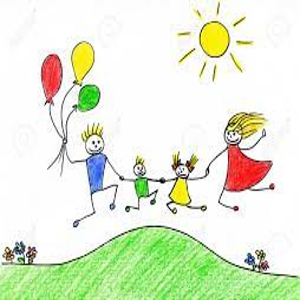

In [56]:
image_file = '/Users/abhishekkashyap/Desktop/dd.jpeg'
data = predict(image_file, trained_model)
img = Image.open(image_file)
img = img.resize((300,300))
print('Input image: ')
display(img)
values = list(list(zip(*data))[0])
keys = list(list(zip(*data))[1])


In [ ]:
print('Expected Child emotions: ')
plt.subplot(1, 2, 1)  
plt.pie(values, labels = keys)

plt.subplot(1, 2, 2)
plt.bar(keys,values, width = 0.4)
plt.xticks(rotation='vertical')
plt.tight_layout(h_pad=5, w_pad=5)
plt.show()